In [ ]:
import re
from pathlib import Path
from torch.utils.data import Dataset
from collections import namedtuple
from pathlib import Path
import numpy as np
import unicodedata
import string
import copy
import matplotlib.pyplot as plt
import math
import pickle

from torch.utils.data import Dataset, DataLoader
%pip install tensorboard
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch
from torch.nn import functional as F




In [ ]:
import os
import glob

from torchnlp.download import download_file_maybe_extract


def imdb_dataset(directory='data/',
                 train=True,
                 test=True,
                 train_directory='train',
                 test_directory='test',
                 extracted_name='aclImdb',
                 check_files=['aclImdb/README'],
                 url='http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
                 sentiments=['pos', 'neg']):
    """
    Load the IMDB dataset (Large Movie Review Dataset v1.0).

    This is a dataset for binary sentiment classification containing substantially more data than
    previous benchmark datasets. Provided a set of 25,000 highly polar movie reviews for
    training, and 25,000 for testing. There is additional unlabeled data for use as well. Raw text
    and already processed bag of words formats are provided.

    Note:
        The order examples are returned is not guaranteed due to ``iglob``.

    **Reference:** http://ai.stanford.edu/~amaas/data/sentiment/

    Args:
        directory (str, optional): Directory to cache the dataset.
        train (bool, optional): If to load the training split of the dataset.
        test (bool, optional): If to load the test split of the dataset.
        train_directory (str, optional): The directory of the training split.
        test_directory (str, optional): The directory of the test split.
        extracted_name (str, optional): Name of the extracted dataset directory.
        check_files (str, optional): Check if these files exist, then this download was successful.
        url (str, optional): URL of the dataset ``tar.gz`` file.
        sentiments (list of str, optional): Sentiments to load from the dataset.

    Returns:
        :class:`tuple` of :class:`iterable` or :class:`iterable`:
        Returns between one and all dataset splits (train, dev and test) depending on if their
        respective boolean argument is ``True``.

    Example:
        >>> from torchnlp.datasets import imdb_dataset  # doctest: +SKIP
        >>> train = imdb_dataset(train=True)  # doctest: +SKIP
        >>> train[0:2]  # doctest: +SKIP
        [{
          'text': 'For a movie that gets no respect there sure are a lot of memorable quotes...',
          'sentiment': 'pos'
        }, {
          'text': 'Bizarre horror movie filled with famous faces but stolen by Cristina Raines...',
          'sentiment': 'pos'
        }]
    """
    download_file_maybe_extract(url=url, directory=directory, check_files=check_files)

    ret = []
    splits = [
        dir_ for (requested, dir_) in [(train, train_directory), (test, test_directory)]
        if requested
    ]
    for split_directory in splits:
        full_path = os.path.join(directory, extracted_name, split_directory)
        examples = []
        for sentiment in sentiments:
            for filename in glob.iglob(os.path.join(full_path, sentiment, '*.txt')):
                with open(filename, 'r', encoding="utf-8") as f:
                    text = f.readline()
                examples.append({
                    'text': text,
                    'sentiment': sentiment,
                })
            ret.append(examples)

    if len(ret) == 1:
        return ret[0]
    else:
        return tuple(ret)

In [ ]:
datasets = imdb_dataset()

In [5]:
pickle.dump( datasets, open( "dataset.p", "wb" ) )

In [3]:
datasets = pickle.load( open( "dataset.p", "rb" ) )

In [4]:
test_neg, train_neg, test_pos, train_pos = datasets
test0 = test_neg + test_pos
train0 = train_neg + train_pos

In [5]:
words = []
idx = 0
word2idx = {}
idx2word = {}
embeddings = []
from pathlib import Path

with open(Path('glove.6B.50d.txt'), 'rb') as f:
    for l in f:
        line = l.decode().split()
        word = line[0]
        words.append(word)
        word2idx[word] = idx
        idx2word[idx] = word
        idx += 1
        vect = np.array(line[1:]).astype(np.float)
        if len(vect) != 50 :
            print (idx, len(vect), l)
        embeddings.append(vect)
    
embeddings = torch.tensor(embeddings)

In [6]:
EMBEDDING_SIZE = 50
b_size = 32

Batch = namedtuple("Batch", ["text", "labels"])
class FolderText(Dataset):
    def __init__(self, classes, tokenizer, load=False):
        self.tokenizer = tokenizer
        self.files = []
        self.filelabels = []
        self.labels = ['pos', 'neg']
        for couple in classes:
            self.files.append(couple['text'])
            self.filelabels.append(couple['sentiment'])

    def __len__(self):
        return len(self.filelabels)
    
    def __getitem__(self, ix):
        return self.files[ix], self.filelabels[ix]
    
    @staticmethod
    def collate(batch):
        data = [item[0] for item in batch]
        labels = [item[1] for item in batch]
        labels = [0 if x =='neg' else 1 for x in labels]
        n = max([len(item) for item in data])
        data = [[word2idx[x] for x in item] + [0]*(n - len(item)) for item in data]
        return Batch(torch.LongTensor(data), torch.LongTensor(labels))

LETTRES = string.ascii_letters + '\'' + string.digits +' '
def normalize(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if c in LETTRES)

WORDS = re.compile(r"\S+")
def tokenizer(t):
    return list([x for x in re.findall(WORDS, t.lower()) if word2idx.get(x) != None])

In [15]:
from IPython.display import display
test = copy.deepcopy(test0)
train = copy.deepcopy(train0)

#On limite la taille des séquences pour éviter une saturation de la mémoir GPU
print('pre-processing:', 'train')
dh = display('wait',display_id=True)
for index, couple in enumerate(train0):
    seq = tokenizer(normalize(couple['text']))
    if len(seq) > 500 :
        seq = seq[::500]
    train[index]['text'] = seq
    if index % int(len(train)/100) == 0 :
        dh.update(str( int(index/len(train) * 100) )+ '% done')

print('pre-processing:', 'test')
dj = display('wait',display_id=True)
for index, couple in enumerate(test0):
    seq = tokenizer(normalize(couple['text']))
    if len(seq) > 500 :
        seq = seq[::500]
    test[index]['text'] = seq
    if index % int(len(test)/100) == 0 :
        dj.update(str(int(index/len(test) * 100)) + '% done')

pre-processing: train


'99% done'

pre-processing: test


'99% done'

In [26]:
train_data = FolderText(train, tokenizer, load=False) 
test_data = FolderText(test, tokenizer, load=False)

train_loader = DataLoader(train_data,  shuffle=True ,  batch_size=b_size,
                      collate_fn=FolderText.collate)  
test_loader = DataLoader(test_data,  shuffle=True ,  batch_size=b_size,
                      collate_fn=FolderText.collate)  

In [38]:
X, y = next(iter(train_loader))
X.shape

torch.Size([32, 341])

In [16]:
class PositionalEncoder(nn.Module):
    def __init__(self, d_model, max_seq_len = 500):
        super().__init__()
        self.d_model = d_model
        
        # create constant 'pe' matrix with values dependant on 
        # pos and i
        pe = torch.zeros(max_seq_len, d_model)
        for pos in range(max_seq_len):
            for i in range(0, d_model, 2):
                pe[pos, i] = \
                math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = \
                math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))
                
        pe = pe.unsqueeze(0).cpu()
        self.register_buffer('pe', pe)
 
    
    def forward(self, x):
        # make embeddings relatively larger
        x = x * math.sqrt(self.d_model)
        #add constant to embedding
        seq_len = x.shape[1]
        b = torch.autograd.Variable(self.pe[:,:seq_len], requires_grad=False)
        x = x + b.cuda()
        del b
        return x

In [17]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim_embedding, heads, dropout = 0.1):
        super().__init__()
        
        self.dim_embedding = dim_embedding
        self.d_k = dim_embedding // heads
        self.h = heads
        
        self.Query = nn.Linear(dim_embedding, dim_embedding)
        self.Value = nn.Linear(dim_embedding, dim_embedding)
        self.Key = nn.Linear(dim_embedding, dim_embedding)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(dim_embedding, dim_embedding)
    
    def forward(self, q, k, v):
        
        bs = q.size(0)
        
        
        k = self.Key(k).view(bs, -1, self.h, self.d_k)
        q = self.Query(q).view(bs, -1, self.h, self.d_k)
        v = self.Value(v).view(bs, -1, self.h, self.d_k)
        
        # [bs * h * sl * dim_embedding]
       
        k = k.transpose(1,2)
        q = q.transpose(1,2)
        v = v.transpose(1,2)
        
        #Calcul de l'attention
        scores = torch.matmul(q, k.transpose(-2, -1)) /  math.sqrt(self.d_k)
        scores = F.softmax(scores, dim=-1)
        #scores = self.dropout(scores)
        res = torch.matmul(scores, v)
        
        # concat
        concat = res.transpose(1,2).contiguous().view(bs, -1, self.dim_embedding)
        output = self.out(concat)
    
        return output

In [18]:
class TransformerLayer(nn.Module):
    def __init__(self, dim_embedding, heads):
        super().__init__()
        self.norm_1 = nn.BatchNorm1d(dim_embedding, eps=1e-06, momentum=0.1)
        self.norm_2 = nn.BatchNorm1d(dim_embedding, eps=1e-06, momentum=0.1)
        self.attn = MultiHeadAttention(dim_embedding, heads)
        self.output = nn.Linear(dim_embedding, dim_embedding)
        
    def forward(self, x):
        #normalisation ( pour n*C*L se fait sur C, il faut échanger les dimensions)
        x2 = self.norm_1(x.transpose(1, 2))
        x2 = x2.transpose(1, 2)
        
        x = x + self.attn(x2,x2,x2)
        
        #normalisation
        x2 = self.norm_2(x.transpose(1, 2))
        x2 = x2.transpose(1, 2)
        
        x = F.relu(x + self.output(x2))
        return x

In [23]:
class Transformer(nn.Module):
    def __init__(self, dim_embedding, heads, nb_class):
        super().__init__()
        self.dim_embedding = dim_embedding
        self.Embedding = nn.Embedding.from_pretrained(embeddings, freeze = True, padding_idx= 0)
        self.pe = PositionalEncoder(dim_embedding)
        self.attention_1 = TransformerLayer(dim_embedding, heads)
        self.attention_2 = TransformerLayer(dim_embedding, heads)
        self.attention_3 = TransformerLayer(dim_embedding, heads)
        self.out = nn.Linear(dim_embedding, nb_class)
        
    def forward(self, src ):
        x = self.Embedding(src)
        x = self.pe(x)
        x = self.attention_1(x)
        x = self.attention_2(x)
        x = self.attention_3(x)
        x = torch.mean(x, 1)
        x = self.out(x)
        return x

In [20]:
m = MultiHeadAttention(50, 5).float()
Embedding = nn.Embedding.from_pretrained(embeddings, freeze = True, padding_idx= 0)
dataLoader = DataLoader(train_data,  shuffle=True ,  batch_size=8,
                  collate_fn=FolderText.collate) 
X, y = next(iter(dataLoader))
X = X
X = Embedding(X).float()
print(X.shape)
y_hat = m(X, X, X)
print(y_hat.shape)

torch.Size([8, 353, 50])
torch.Size([8, 353, 50])


In [ ]:
m = Transformer(50, 5, 2).float()
dataLoader = DataLoader(train_data,  shuffle=True ,  batch_size=8,
                  collate_fn=FolderText.collate) 
X, y = next(iter(dataLoader))
#X = Embedding(X)
#X = X.double()
print(X.shape)
#y_hat = m(X, X, X)
X = X
y_hat = m(X)
print(y_hat.shape)

In [39]:
dim_embedding = 50
b_size = 32
heads = 2
nb_class = 2
epochs = 20





model = Transformer(dim_embedding, heads, nb_class).float()
#model = torch.load('mem.txt')

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_function = nn.CrossEntropyLoss()
writer = SummaryWriter()
loss = []
min_loss = 10
loss_val = 1000
savepath = Path("mem.txt")

CUDA = torch.cuda.is_available() 
if CUDA:
    print("GPU is available")
    model = model.cuda()
    loss_function = loss_function.cuda() 


if __name__ == '__main__':
    dataLoader = DataLoader(train_data,  shuffle=True ,  batch_size=b_size, num_workers=0,
                  collate_fn=FolderText.collate) 
    data_len = int(len(dataLoader.dataset)/b_size)
    print("nombre de batch: ", data_len)
    de = display('epoch:',display_id=True)
    di = display('iteration:',display_id=True)
    for e in range(epochs):
        de.update('epoch: '+ str(e) + '/' + str(epochs))
        for i, (batch_X, batch_y) in enumerate(dataLoader):
            if CUDA:
                batch_X = batch_X.cuda()
                batch_y= batch_y.cuda()
        
            #========forward pass=====================================
            y_hat = model(batch_X)
            loss_val = loss_function(y_hat, batch_y)
            writer.add_scalar('Loss/train', loss_val)
            loss.append(loss_val)
        
            #print process status
            if i % int(data_len / 10) == 0:
                di.update("itération:" + str(i) + "| loss:" + str(loss_val.item()))
            #save minimum after 80% of the execution time
            if ( e >= 0.8*epochs ) and (loss_val < min_loss):
                min_loss = loss_val
                with savepath.open("wb") as fp:
                    torch.save(model, fp)

            #=======backward pass=====================================
            optimizer.zero_grad() # zero the gradients 
            loss_val.backward()
            optimizer.step()
            del batch_X, batch_y, y_hat


GPU is available
nombre de batch:  1109


'epoch: 19/20'

'itération:1100| loss:0.36135241389274597'

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Transformer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type PositionalEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type TransformerLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type MultiHeadAttention. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be chec

In [29]:
#Clear data
!nvidia-smi
del model, optimizer, dataLoader
torch.cuda.empty_cache()
!nvidia-smi


Mon Feb  3 13:06:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro M4000        On   | 00000000:00:05.0 Off |                  N/A |
| 46%   25C    P8    11W / 120W |    644MiB /  8126MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

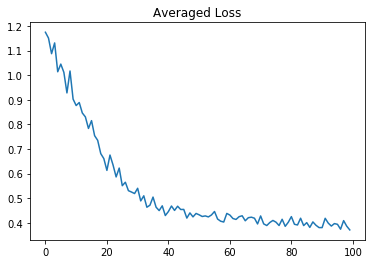

In [40]:
d_loss = [torch.mean(torch.tensor(loss[i*100 : (i+1)*100])) for i in range(100)]
plt.plot(d_loss)
plt.title('Averaged Loss')
plt.show()

## Résultats:

La meilleur loss est amélioré par rapport au modèle simplifié précédent. 

In [41]:
pickle.dump( d_loss, open( "loss1.p", "wb" ) )

# Exo 2:

Embedding de la position 


In [ ]:
!pip install seaborn

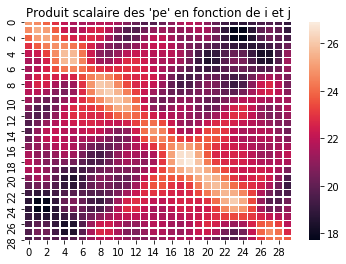

In [46]:
M = []
pe_fun = PositionalEncoder(50)
pe_fun.pe = pe_fun.pe.squeeze(0)
for i in range (30):
    ligne = []
    for j in range(30):
        dot = torch.dot(pe_fun.pe[i,:], pe_fun.pe[j,:])
        ligne.append(dot.item())
    M.append(ligne)


import seaborn as sns
plt.title('Produit scalaire des \'pe\' en fonction de i et j')
sns.heatmap(M, linewidth=0.5)
plt.show()

On remarque que plus i et j sont proches (points de la diagonale) plus le produit scalaire des positional embedding est élevé. Au contraire aus extrémités la valeur est la plus faible. Cela va bien permettre de distinguer les points selon leur position. On remarque aussi que l'information est stockée sur une certaine fréquence (si on voit les points comme des échantillonages de fonction).

# Exo 3

Ajout d'un token CLS et le résultat est calculé au niveau de ce token.

In [ ]:
class TransformerCLS(nn.Module):
    def __init__(self, dim_embedding, heads, nb_class):
        super().__init__()
        self.dim_embedding = dim_embedding
        self.Embedding = nn.Embedding.from_pretrained(embeddings, freeze = True, padding_idx= 0)
        self.EmbeddingCLS = torch.nn.Parameter(torch.randn(dim_embedding))
        self.pe = PositionalEncoder(dim_embedding)
        self.attention_1 = TransformerLayer(dim_embedding, heads)
        self.attention_2 = TransformerLayer(dim_embedding, heads)
        self.attention_3 = TransformerLayer(dim_embedding, heads)
        self.out = nn.Linear(dim_embedding, nb_class)
        
    def forward(self, src ):
        b_size = src.shape[0]
        xi = self.Embedding(src[:,1:])
        x0 = self.EmbeddingCLS.repeat(b_size, 1)
        x0 = x0.unsqueeze(1)
        x = torch.cat([x0, xi], dim=1)
        x = self.pe(x)
        x = self.attention_1(x)
        x = self.attention_2(x)
        x = self.attention_3(x)
        x = x[:,0,:]
        x = self.out(x)
        return x

In [ ]:
test = copy.deepcopy(test0)
train = copy.deepcopy(train0)

#On limite la taille des séquences pour éviter une saturation de la mémoire GPU
#Ajout du token CLS
print('pre-processing:', 'train')
dh = display('wait',display_id=True)
for index, couple in enumerate(train0):
    seq = tokenizer(normalize(couple['text']))
    if len(seq) > 499 :
        seq = seq[::500]
    train[index]['text'] = ['CLS'] + seq
    if index % int(len(train)/100) == 0 :
        dh.update(str( int(index/len(train) * 100) )+ '% done')

print('pre-processing:', 'test')
dj = display('wait',display_id=True)
for index, couple in enumerate(test0):
    seq = tokenizer(normalize(couple['text']))
    if len(seq) > 499 :
        seq = seq[::500]
    test[index]['text'] = ['CLS'] + seq
    if index % int(len(test)/100) == 0 :
        dj.update(str(int(index/len(test) * 100)) + '% done')
        
#Ajout du Token CLS dans le dictionnaire
#idx = 400001
word2idx['CLS'] = idx
idx2word[idx] = 'CLS'
        
train_data = FolderText(train, tokenizer, load=False) 
test_data = FolderText(test, tokenizer, load=False)

train_loader = DataLoader(train_data,  shuffle=True ,  batch_size=b_size,
                      collate_fn=FolderText.collate)  
test_loader = DataLoader(test_data,  shuffle=True ,  batch_size=b_size,
                      collate_fn=FolderText.collate)  

In [ ]:
m = TransformerCLS(50, 5, 2).float().cuda()
dataLoader = DataLoader(train_data,  shuffle=True ,  batch_size=8,
                  collate_fn=FolderText.collate) 
X, y = next(iter(dataLoader))
X = X.cuda()
print(X.shape)
y_hat = m(X)
print(y_hat.shape)

In [ ]:
dim_embedding = 50
b_size = 32
heads = 5
nb_class = 2
epochs = 20





model = TransformerCLS(dim_embedding, heads, nb_class).float()
#model = torch.load('mem.txt')

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_function = nn.CrossEntropyLoss()
writer = SummaryWriter()
loss = []
min_loss = 10
loss_val = 1000
savepath = Path("memCLS.txt")

CUDA = torch.cuda.is_available() 
if CUDA:
    print("GPU is available")
    model = model.cuda()
    loss_function = loss_function.cuda() 


if __name__ == '__main__':
    dataLoader = DataLoader(train_data,  shuffle=True ,  batch_size=b_size, num_workers=0,
                  collate_fn=FolderText.collate) 
    data_len = int(len(dataLoader.dataset)/b_size)
    print("nombre de batch: ", data_len)
    de = display('epoch:',display_id=True)
    di = display('iteration:',display_id=True)
    for e in range(epochs):
        de.update('epoch: '+ str(e) + '/' + str(epochs))
        for i, (batch_X, batch_y) in enumerate(dataLoader):
            if CUDA:
                batch_X = batch_X.cuda()
                batch_y= batch_y.cuda()
        
            #========forward pass=====================================
            y_hat = model(batch_X)
            loss_val = loss_function(y_hat, batch_y)
            writer.add_scalar('Loss/train', loss_val)
            loss.append(loss_val)
        
            #print process status
            if i % int(data_len / 10) == 0:
                di.update("itération:" + str(i) + "| loss:" + str(loss_val.item()))
            #save minimum after 80% of the execution time
            if ( e >= 0.8*epochs ) and (loss_val < min_loss):
                min_loss = loss_val
                with savepath.open("wb") as fp:
                    torch.save(model, fp)

            #=======backward pass=====================================
            optimizer.zero_grad() # zero the gradients 
            loss_val.backward()
            optimizer.step()
            del batch_X, batch_y, y_hat


With This methodd the results are almost the same. The loss is about 0.5 after 300 iterations.